In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# external modules
import numpy as np
from pathlib import Path

# local modules
import simulator
import spectra


In [3]:
# define wavelength range and spacing for simulations as
# 1-4 micron at 5nm intervals
WLS = np.linspace(1, 4, 601)

# set the total number of simulations to run
num_spectra = 100

# Total water measured from step-heating experiments
water_ppm = [1522, 762, 176, 22]


In [4]:
# Low wavelength portion of MORB spectrum (<1.5 microns)
MORB_D38A_LowLam = spectra.spectrum_from_file(
    Path("../data/Morb_D38A_Low_wavelength.txt")
)


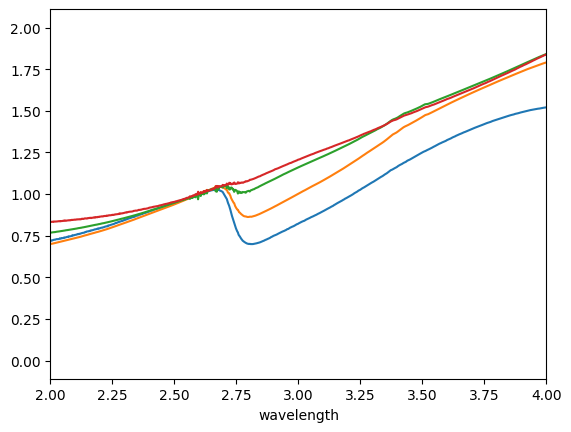

In [14]:
# MORB step-wise heating spectra
heated_MORB_spectra = []
interpolated_spectra = []
norm_factor = 1
for temperature in [650, 700, 750, 800]:
    MORB_spectrum = spectra.spectrum_from_file(
            Path(f"../data/{temperature}^oC.csv"), name=f'{temperature}C')
    MORB_spectrum.index = 1e4 / MORB_spectrum.index  # 1/cm to microns
    MORB_spectrum = MORB_spectrum / 100  # percent to decimal
    MORB_spectrum = MORB_spectrum.sort_index()
    
    # Normalize all MORB spectra to the reflectance at 2.6 microns at the
    # lowest water amount and highest temperature (22 ppm, 800 C)
    norm_factor = spectra.get_normalization_factor(MORB_spectrum, 2.6)
    normalized_spectrum = MORB_spectrum / norm_factor
    normalized_spectrum.squeeze()
    
    normalized_spectrum.plot(xlim=(2,4))
    heated_MORB_spectra.append(normalized_spectrum)


In [12]:
ssa = []
for spectrum in heated_MORB_spectra:
    # interpolate along our sampling grid of interest
    interpolated_spectrum = simulator.interpolate_series(spectrum, WLS)

    # Use Hapke model to convert from laboratory reflectance to single
    # scattering albedo using reflectance and scattering asymmetry
    # factor (p) of 0.81 (see manuscript for details on Hapke model)
    ssa.append(simulator.reflectance_to_ssa(
        reflectance=interpolated_spectrum, asymmetry_factor=0.81))


TypeError: can only concatenate tuple (not "float") to tuple